# Avaliação 3

**Alunos: Andreza Ísis Santos da Costa, Ecília Silva de Oliveira e Silas Henrique Alves Araújo**

Considere a modelagem da distribuição de temperatura em um dissipador em forma de pino usado para resfriar um objeto. Se convecção e radiação forem incluídas na análise, a temperatura $T(t,x)$ ao longo do dissipador pode ser obtida com a solução de uma equação na forma
\begin{align}
\frac{\partial T(t,x)}{\partial t} &= \beta\frac{d^2T}{dx^2} -k_0 \left(T(t,x) - T_s\right) - k_1 \left(T^4(t,x) - T_s^4\right) \\
\end{align}
onde $k = [1.67, ~9.45\times 10^{-10}]$, $\beta = 1\times 10^{-2}$, $L= 0.5$ são parâmetros do sistema, $T_s=293$K é a temperatura ambiente, $T(t,x)$ é a Temperatura em função do tempo e do comprimento, $x$, da barra.

Dada as seguintes condições de contorno
$\begin{cases}
T(0,x) &= 493.0\\
T(t,0) &= 493.0\\
\frac{\partial T(t,x)}{\partial x}|_{x=L} & = 0
\end{cases}$,
pede-se:

1.  (3,0) Quanto tempo o sistema leva para atingir o estado estacionário?
2.  (5,0) Determine os melhores parâmetros $k$ que resultam em um resfriamento mais rápido para temperatura no final do pino $T(t,L)$, sabendo que:
    \begin{align}
    &0 \leq k_0 \leq 3.5\\
    &0 \leq k_1 \leq 2.0\times 10^{-9}
    \end{align}
3.  (2,0) Compare os tempos de resfriamentos obtidos


## Definindo sistema


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Definir constantes
L = 0.5
Ts = 293
beta = 1e-2

# Discretização do espaço
n_x = 50  # Número de pontos em x
x = np.linspace(0, L, n_x)
dx = x[1] - x[0]

# Discretização do tempo
n_t = 1000  # Número de pontos em t
tf = 6  # Tempo final da simulação
t = np.linspace(0, tf, n_t)

# Definindo estado inicial
T0 = np.full(n_x, 493)  # T(0,x) = 493


def edp(t, T, args):
    # Extraindo parâmetros
    k0, k1 = args
    # Criando o array
    dTdt = np.zeros(n_x)

    # Condição de contorno T(t,0) = 493 (como todo o valor de T para x=0 é igual, então a derivada ali é zero)
    # dTdt[0] = 0 # Podemos comentar pois o np.zeros já iniciou o array como zeros.
    for i in range(1, n_x - 1):
        d2Tdx2 = (T[i - 1] - 2 * T[i] + T[i + 1]) / (dx**2)
        dTdt[i] = beta * d2Tdx2 - k0 * (T[i] - Ts) - k1 * (T[i] ** 4 - Ts**4)
    # Condição de contorno dTdx(t,L) = 0 (logo, não haverá diferença entre o último ponto e o penúltimo)
    dTdt[-1] = dTdt[-2]

    return dTdt

## Fazendo primeira simulação


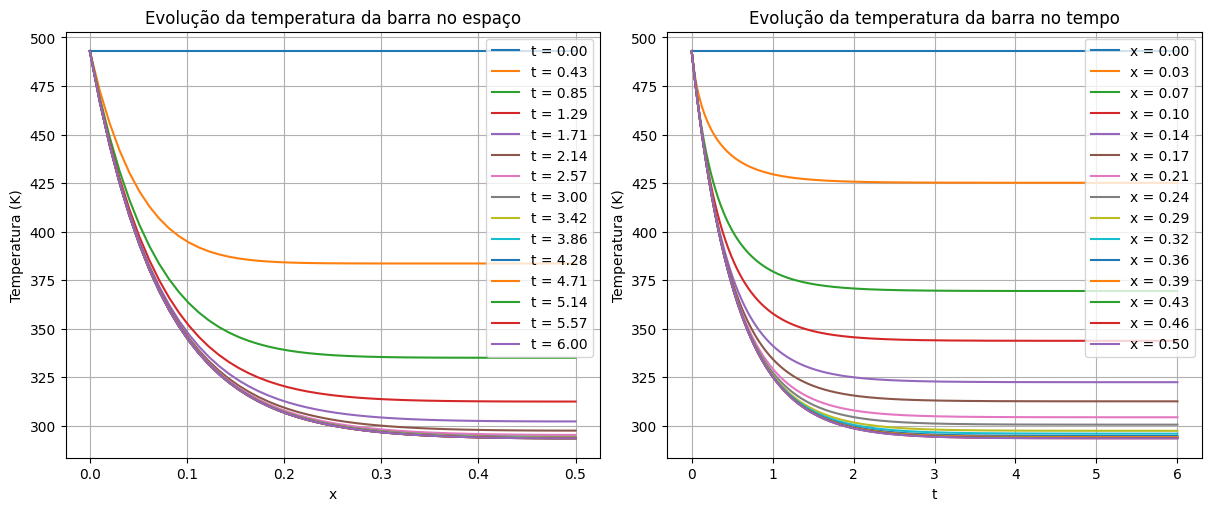

In [2]:
# Simulando com os parâmetros k dados na questão
k = [1.67, 9.45e-10]
# Simulando com os parâmetros rtol e atol menores que os padrões para aumentar a qualidade da simulação
sol = solve_ivp(edp, [0, tf], T0, t_eval=t, args=(k,), rtol=1e-10, atol=1e-10)

# Plotando solução

# Limitando a quantidade de linhas no gráfico para não poluir
t_values = np.linspace(0, n_t - 1, 15, dtype=int)
x_values = np.linspace(0, n_x - 1, 15, dtype=int)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

axes[0].set_title("Evolução da temperatura da barra no espaço")
axes[0].set_xlabel("x")
for i in t_values:
    axes[0].plot(x, sol.y[:, i], label=f"t = {t[i]:.2f}")

axes[1].set_title("Evolução da temperatura da barra no tempo")
axes[1].set_xlabel("t")
for i in x_values:
    axes[1].plot(sol.t, sol.y[i, :], label=f"x = {x[i]:.2f}")


for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_ylabel("Temperatura (K)")

plt.show()

## Descobrindo quanto tempo leva para o sistema atingir o estado estacionário

A rigor, matematicamente, sistemas como esse só se estabilizam completamente no infinito, pois as variações continuam a ocorrer, ainda que de forma cada vez menor (com a derivada se aproximando de zero). Por isso que, na prática, precisamos definir um critério arbitrário para determinar quando consideramos o sistema estabilizado. Esse critério envolve a escolha de um valor de tolerância: quando a derivada se torna menor que esse valor, consideramos que o sistema entrou em um estado estacionário.

Aqui, cada ponto $x$ do dissipador pode ser visto como uma função individual porque ele possui uma série de valores de temperatura $T$ que variam ao longo do tempo $t$. Ou seja, para cada posição $x$, podemos observar como a temperatura muda com o tempo. O sistema é considerado estabilizado quando o último ponto $x$ atinge estabilidade, ou seja, no primeiro tempo $t$ que todas as derivadas dessas curvas são menores que o valor de tolerância definido.


In [3]:
from IPython.display import display, Markdown  # Para imprimir com markdown


def derivada(x, y):
    """
    Calcula a derivada numérica de uma função dada por y=f(x).
    """
    dydx = np.zeros(len(x))
    for i in range(len(x)):
        if i == 0:
            dydx[i] = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
        elif i == (len(x) - 1):
            dydx[i] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
        else:
            dydx[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1])
    return dydx


def detectar_estabilização(x, y, tol=0.1):
    """
    Retorna o primeiro valor de x em que uma função "y=f(x)" estabiliza.
    """
    dydx = derivada(x, y)
    for i in range(len(dydx)):
        if np.abs(dydx[i]) < tol:
            return x[i]
    # Lançar erro caso o sistema nunca estabilize dentro do intervalo fornecido.
    raise ValueError("Não foi possível detectar estabilização")


def detectar_estabilização_sistema(x, y):
    """
    Retorna o primeiro tempo t em que todas as funções de um sistema estão no estado estacionário.
    """
    t_max_estável = 0
    for i in range(n_x):
        t_estável = detectar_estabilização(sol.t, sol.y[i])
        if t_estável > t_max_estável:
            t_max_estável = t_estável

    return t_max_estável


t_estável = detectar_estabilização_sistema(sol.t, sol.y[i])

# Imprimindo resultado:

display(
    Markdown(
        rf"""
### 1. Quanto tempo o sistema leva para atingir o estado estacionário?

Podemos considerar que a partir de $t={t_estável:.2f}$, o sistema está em estado estacionário.
"""
    )
)


### 1. Quanto tempo o sistema leva para atingir o estado estacionário?

Podemos considerar que a partir de $t=4.46$, o sistema está em estado estacionário.


## Otimizando o tempo de resfriamento no final do pino

Para determinar os melhores parâmetros $k$ que resultam em um resfriamento mais rápido da temperatura no final do pino $T(t,L)$, precisamos otimizar de modo que o processo de resfriamento no ponto $x=L$ termine no menor tempo $t$ possível. Consideramos que esse processo encerra quando a função entra no estado estacionário.

Para testar isso podemos reaproveitar a função `detectar_estabilização` na função objetivo `tempo_por_k` que calcula o tempo de estabilização simulando o sistema para parâmetros $k$ quaisquer, retornando o tempo em que o sistema se estabiliza. E em seguida minimizar essa função para achar os valores de $k$ que fazem o sistema estabilizar o mais cedo possível.


In [4]:
from scipy.optimize import minimize


# Função para minimizar
def tempo_por_k(k: list[float]):
    sol = solve_ivp(edp, [0, tf], T0, t_eval=t, args=(k,), rtol=1e-10, atol=1e-10)
    return detectar_estabilização(sol.t, sol.y[-1, :])


limites = [(0, 3.5), (0, 2e-9)]
estimativas_k = k  # Utilizar os valores de k0 e k1 da questão como estimativa inicial parece ser razoável.

res = minimize(
    tempo_por_k,
    estimativas_k,
    bounds=limites,
    # Após muitos testes, foi observado que a função tempo_por_k não responde bem
    # para pequenas variações, pois o tempo de simulação é discreto.
    # O método TNC foi o que deu os melhores resultados nos testes, mas também
    # foi necessário usar o parâmetro "eps", que força o otimizador a dar
    # passos maiores para o calculo do jacobiano.
    method="TNC",
    options={"eps": 0.1},
)

t_resfriamento = detectar_estabilização(sol.t, sol.y[-1, :])
t_resfriamento_otimizado = res.fun

sol_otimizada = solve_ivp(edp, [0, tf], T0, t_eval=t, args=(res.x,))


# Imprimindo resultado
display(
    Markdown(
        rf"""
### 2. Determine os melhores parâmetros $k$ que resultam em um resfriamento mais rápido para temperatura no final do pino $T(t,L)$

Minimizado a função `tempo_por_k`, obtemos que os parâmetros otimizados são $k_0 = {res.x[0]:.2f}$ e $k_1 = {res.x[1]:.2e}$, que resultam que no tempo $t = {t_resfriamento_otimizado:.2f}$ o final do pino já encerrou o processo de resfriamento.
"""
    )
)


### 2. Determine os melhores parâmetros $k$ que resultam em um resfriamento mais rápido para temperatura no final do pino $T(t,L)$

Minimizado a função `tempo_por_k`, obtemos que os parâmetros otimizados são $k_0 = 3.50$ e $k_1 = 2.00e-09$, que resultam que no tempo $t = 2.38$ o final do pino já encerrou o processo de resfriamento.


## Comparando os tempos de resfriamento

Os parâmetros $k0$ e $k1$ influenciam diretamente na forma como o calor é dissipado no sistema, afetando o resfriamento da temperatura no final do pino. Elas estão relacionadas justamente com a perca de calor para o ambiente na forma de convecção e radiação, então faz sentido que os valores encontrados pelo _minimize_, sejam os maiores possíveis nos limites especificados.


In [5]:
# Calculando a diferença entre os tempos de resfriamento obtidos com os parâmetros originais e os otimizados

# Calculando a diferença entre os tempos de estabilização
diferença_tempo = t_resfriamento - t_resfriamento_otimizado

# Exibindo a comparação dos tempos de resfriamento e a diferença
display(
    Markdown(
        rf"""
### 3. Compare os tempos de resfriamentos obtidos

- **Tempo de resfriamento com os parâmetros originais:** $t = {t_resfriamento:.2f}$.
- **Tempo de resfriamento com os parâmetros otimizados:** $t = {t_resfriamento_otimizado:.2f}$.
- **Diferença de tempo de resfriamento:** ${diferença_tempo:.2f}$.

A otimização dos parâmetros $k_0$ e $k_1$ resultou em um resfriamento mais rápido, reduzindo o tempo de resfriamento em ${diferença_tempo:.2f}$.
"""
    )
)


### 3. Compare os tempos de resfriamentos obtidos

- **Tempo de resfriamento com os parâmetros originais:** $t = 4.46$.
- **Tempo de resfriamento com os parâmetros otimizados:** $t = 2.38$.
- **Diferença de tempo de resfriamento:** $2.08$.

A otimização dos parâmetros $k_0$ e $k_1$ resultou em um resfriamento mais rápido, reduzindo o tempo de resfriamento em $2.08$.


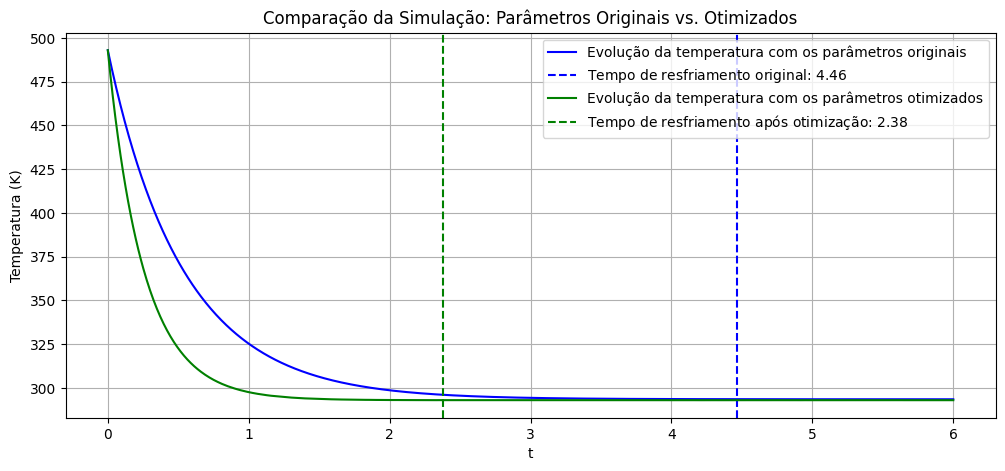

In [6]:
# Criando um gráfico comparativo para os tempos de resfriamento com parâmetros originais e otimizados

# Configurando o gráfico único para comparar as duas simulações
plt.figure(figsize=(12, 5))
plt.title("Comparação da Simulação: Parâmetros Originais vs. Otimizados")

# Plotagem dos parâmetros originais
plt.plot(
    t,
    sol.y[-1, :],
    label="Evolução da temperatura com os parâmetros originais",
    color="blue",
)
plt.axvline(
    x=t_estável,
    color="blue",
    linestyle="--",
    label=f"Tempo de resfriamento original: ${t_estável:.2f}$",
)

# Plotagem dos parâmetros otimizados
plt.plot(
    t,
    sol_otimizada.y[-1, :],
    label="Evolução da temperatura com os parâmetros otimizados",
    color="green",
)
plt.axvline(
    x=t_resfriamento_otimizado,
    color="green",
    linestyle="--",
    label=f"Tempo de resfriamento após otimização: ${t_resfriamento_otimizado:.2f}$",
)

# Ajustes de rótulos e grid
plt.grid()
plt.ylabel("Temperatura (K)")
plt.xlabel("t")
plt.legend()
plt.show()

A análise dos gráficos evidência a diferença nos tempos de resfriamento entre as simulações com os parâmetros originais e os otimizados. Com os valores iniciais de $k0$ e $k1$ fornecidos na questão, o final do pino demora mais para alcançar a temperatura do estado estacionário, e assim, terminar o processo de resfriamento.

Após a otimização, os novos valores de $k0$ e $k1$ proporcionam um resfriamento mais rápido, reduzindo o tempo necessário para estabilizar a temperatura. Essa melhoria ocorre porque os parâmetros otimizados aumentam a eficiência na transferência de calor por convecção e radiação, permitindo que o pino atinja o equilíbrio térmico em menos tempo.
